In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC

In [ ]:
# Configuration
limit = True # True to limit the number of features showed in reports for each anaylsis method
k_best = 20 # top k_best features will be shown in reports for each analysis method

In [7]:
output_file_name = "outputs/dataset_experimental_200ms_50ms"
input_file_name = "inputs/dataset_experimental_200ms_50ms.csv"
output_file = open(output_file_name + ".txt", "w")
df = pd.read_csv(input_file_name)

In [8]:
X_train = df.drop('label',axis=1)
y_train = df['label']
audio_features = df.iloc[:, 0:107]
imf_features = df.iloc[:, 107:-1]

# 1. Correlation analysis

In [4]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    with open(output_file_name + "_corelations.csv", "w") as f:
        corr.to_csv(f)

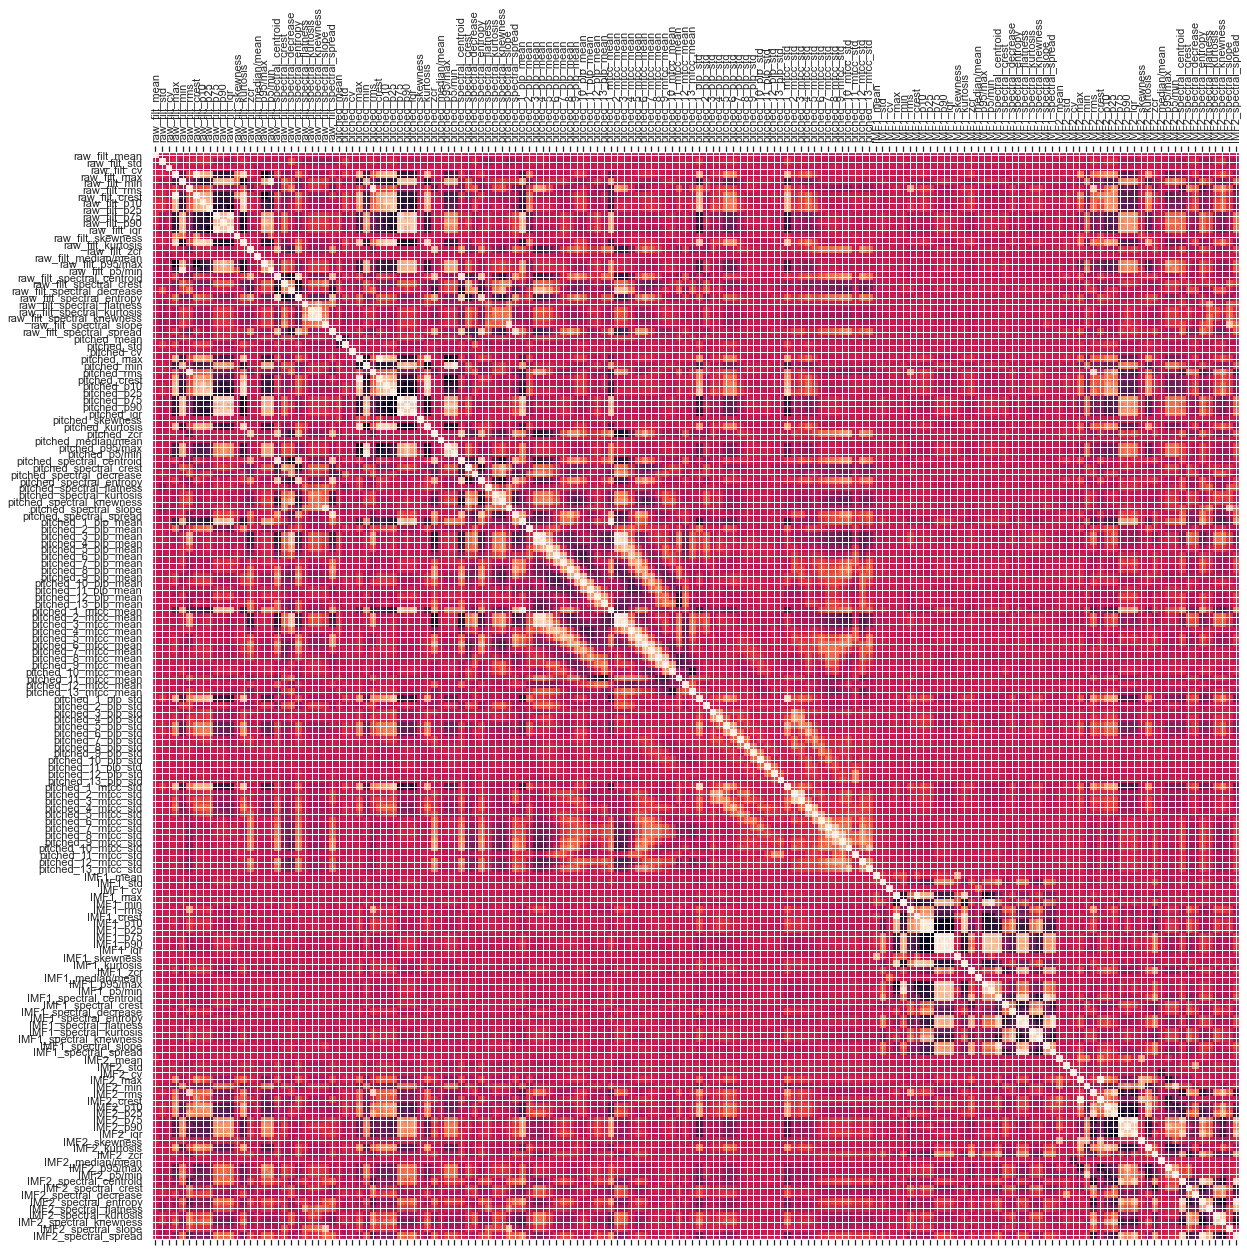

In [5]:
plot_corr(X_train, 20)

# 2. Univariate feature selection
----------

## 2.1. Mutual information


In [14]:
selector = SelectKBest(mutual_info_classif, k=k_best)
selector.fit(X_train, y_train)
scores = selector.scores_
indices = np.argsort(scores)[::-1]
if limit:
    nfeatures = k_best
    indices = indices[range(nfeatures)]
else:
     nfeatures = X_train.shape[1]  

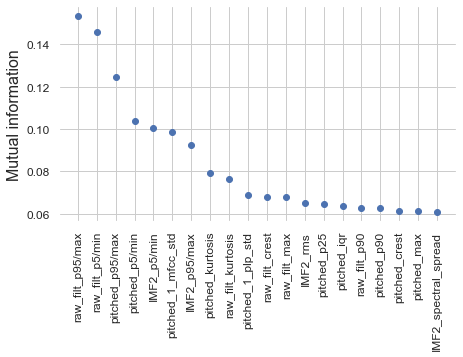

In [15]:
pl.figure(figsize=(6.5, 5)) # This increases resolution
pl.plot(range(nfeatures), scores[indices], 'o')

#pl.title('Univariate feature selection of best ' + str(k_best) + ' features')
pl.ylabel('Mutual information')
pl.xlim([-1, nfeatures])
# pl.ylim([0, 0.2])
pl.xticks(range(nfeatures), df.drop('label',axis=1).columns.values[indices], rotation=90)
pl.tight_layout()

ax = plt.gca()
ax.set_facecolor((1, 1, 1))
ax.grid(which='major', color=(0.8,0.8,0.8), linestyle='-')

ax.yaxis.label.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

pl.savefig(output_file_name + '_MutualInformation_top20.png', format='png', dpi=300)


In [16]:
# Print the feature ranking
output_file.write("MUTUAL INFORMATION\nFeature ranking:\n")

for f in range(nfeatures):
    output_file.write("%d. %s (%f)\n" % (f + 1, df.drop('label',axis=1)\
                                         .columns.values[indices[f]], scores[indices[f]]))

2.2. ANOVA
-----------------

In [17]:
# Supervised univariate feature selection using ANOVA F-value
# as measure of feature's relationship with the target class
selector = SelectKBest(f_classif, k=k_best)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
if limit:
    nfeatures = k_best
    indices = indices[range(nfeatures)]
else:
     nfeatures = X_train.shape[1]   

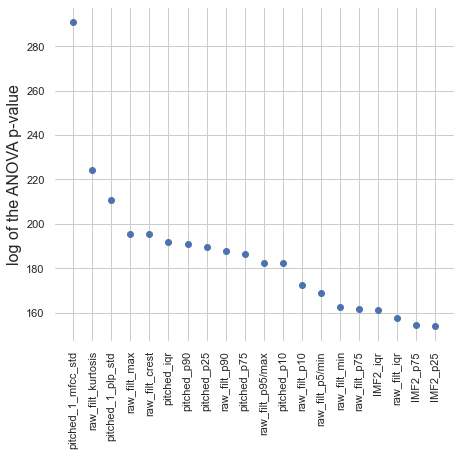

In [18]:

pl.figure(figsize=(6.5, 6.5)) # This increases resolution
pl.plot(range(nfeatures), scores[indices], 'o')

#pl.title('Univariate feature selection of best ' + str(k_best) + ' features')
pl.ylabel('log of the ANOVA p-value')
pl.xlim([-1, nfeatures])
pl.xticks(range(nfeatures), df.drop('label',axis=1).columns.values[indices], rotation=90)
pl.tight_layout()

ax = plt.gca()
ax.set_facecolor((1, 1, 1))
ax.grid(which='major', color=(0.8,0.8,0.8), linestyle='-')

ax.yaxis.label.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

pl.savefig(output_file_name + '_ANOVA_top20.png', format='png', dpi=300)

In [19]:
# Print the feature ranking
output_file.write("\n\nANOVA\nFeature ranking:\n")

for f in range(nfeatures):
    output_file.write("%d. %s (%f)\n" % (f + 1, df.drop('label',axis=1)\
                                         .columns.values[indices[f]], scores[indices[f]]))

# 3. Feature relevances from a predictive model
--------
## 3.1 Random forest

In [20]:
# Feature relevances calculated directly using a random forest classifier
forest_rnk = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
forest_rnk.fit(X_train, y_train)
importances_rf = forest_rnk.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

if limit:
    nfeatures = k_best
    indices_rf = indices_rf[range(nfeatures)]
else:
     nfeatures = X_train.shape[1]   

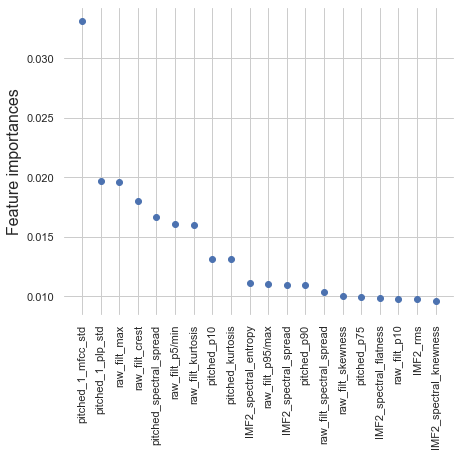

In [25]:
import pylab as pl
pl.figure(figsize=(6.5, 6.5))

pl.plot(range(nfeatures), importances_rf[indices_rf], 'o')

pl.ylabel('Feature importances')
pl.xlim([-1, nfeatures])
pl.xticks(range(nfeatures), df.drop('label',axis=1).columns.values[indices_rf], rotation=90)
pl.tight_layout()

ax = plt.gca()
ax.set_facecolor((1, 1, 1))
ax.grid(which='major', color=(0.8,0.8,0.8), linestyle='-')

ax.yaxis.label.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

pl.savefig(output_file_name + '_Forest.png', format='png', dpi=350)

In [26]:
# Print the feature ranking
output_file.write("\n\n\nRANDOM FOREST\nFeature ranking:\n")

for f in range(nfeatures):
    output_file.write("%d. %s (%f)\n" % (f + 1, df.drop('label',axis=1)\
                                .columns.values[indices_rf[f]], importances_rf[indices_rf[f]]))

3.2. Support Vector Machine Classifier
------------

In [27]:
svc = LinearSVC()
svc.fit(X_train, y_train);

# as we have two classes we have just one set of feature importances
importances_svc = svc.coef_.flatten()
# return indices that would sort an array in reverse
indices_svc = np.argsort(importances_svc)[::-1]

if limit:
    nfeatures = k_best
    indices_svc = indices_svc[range(nfeatures)]
else:
     nfeatures = X_train.shape[1]   

C:\Users\gkrekovic\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


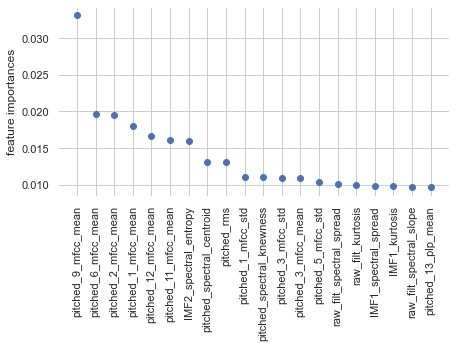

In [28]:
pl.figure(figsize=(6.5, 5))
pl.plot(range(nfeatures), importances_rf[indices_rf], 'o')

pl.ylabel('feature importances')
pl.xlim([-1, nfeatures])
pl.xticks(range(nfeatures), df.drop('label',axis=1).columns.values[indices_svc], rotation=90)
pl.tight_layout()

ax = plt.gca()
ax.set_facecolor((1, 1, 1))
ax.grid(which='major', color=(0.8,0.8,0.8), linestyle='-')

pl.savefig(output_file_name + '_SVC.png', format='png', dpi=350) # This does, too

In [29]:
# Print the feature ranking
output_file.write("\n\n\nSVC\nFeature ranking:\n")

for f in range(nfeatures):
    output_file.write("%d. %s (%f)\n" % (f + 1, df.drop('label',axis=1).columns.values[indices_svc[f]], importances_svc[indices_svc[f]]))

# 4. RFECV
------------

In [30]:
rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, cv=StratifiedKFold(5, shuffle=True), scoring='accuracy')
rfecv_rf.fit(X_train, y_train);

output_file.write("\n\n\nRECURSIVE FEATURE ELIMINATION\n")
output_file.write("Selected combined features with RFECV using Random Forest:\n")
for i in list(X_train.columns.values[rfecv_rf.get_support()]):
    output_file.write(' - ' + str(i) + '\n')

In [31]:
rfecv_rf_audio = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, cv=StratifiedKFold(5, shuffle=True), scoring='accuracy')
rfecv_rf_audio.fit(audio_features, y_train);

output_file.write("\n\nSelected audio features with RFECV using Random Forest:\n")
for i in list(audio_features.columns.values[rfecv_rf_audio.get_support()]):
    output_file.write(' - ' + str(i) + '\n')

In [32]:
rfecv_rf_imf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, cv=StratifiedKFold(5, shuffle=True), scoring='accuracy')
rfecv_rf_imf.fit(imf_features, y_train);

output_file.write("\n\nSelected IMF features with RFECV using Random Forest:\n")
for i in list(imf_features.columns.values[rfecv_rf_imf.get_support()]):
    output_file.write(' - ' + str(i) + '\n')

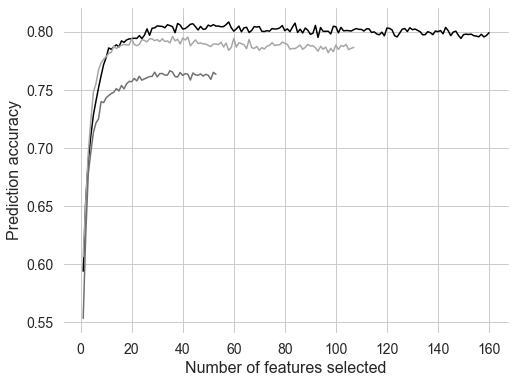

In [36]:
pl.figure(figsize=(8, 6))

pl.plot(range(1, len(rfecv_rf.grid_scores_)+1), rfecv_rf.grid_scores_, '-', color = (0,0,0))
pl.plot(range(1, len(rfecv_rf_audio.grid_scores_) + 1), rfecv_rf_audio.grid_scores_, '-', color = (0.65,0.65,0.65))
pl.plot(range(1, len(rfecv_rf_imf.grid_scores_) + 1), rfecv_rf_imf.grid_scores_, '-', color = (0.44,0.44,0.44))
pl.xlabel('Number of features selected')
pl.ylabel('Prediction accuracy')

#pl.ylim([0.58, 0.76])
ax = plt.gca()
ax.set_facecolor((1, 1, 1))
ax.grid(which='major', color=(0.8,0.8,0.8), linestyle='-')
ax.yaxis.label.set_fontsize(16)
ax.xaxis.label.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

pl.savefig(output_file_name + '_RFE_Forest.png', format='png', dpi=350) # This does, too

In [34]:
output_file.write("\n\n")
output_file.write("Max. audio-based score: " + str(max(rfecv_rf_audio.grid_scores_)))
output_file.write("\nMax. IMF-based score: " + str(max(rfecv_rf_imf.grid_scores_)))
output_file.write("\nMax. score: " + str(max(rfecv_rf.grid_scores_)))
output_file.write("\nScore for all selected audio features: " + str(rfecv_rf_audio.grid_scores_[-1]))
output_file.write("\nScore for all selected IMF features: " + str(rfecv_rf_imf.grid_scores_[-1]))
output_file.write("\nScore for all selected features: " + str(rfecv_rf.grid_scores_[-1]))

31

In [37]:
X_train_selected = X_train.iloc[:, rfecv_rf.support_]
X_train_selected.to_pickle(output_file_name + "_X_train_selected.pkl")
y_train.to_pickle(output_file_name + "_y_train.pkl")

# 5. Classifiers

In [46]:
X_train_selected = pd.read_pickle(output_file_name + "_X_train_selected.pkl")
y_train = pd.read_pickle(output_file_name + "_y_train.pkl")

In [39]:
def validate_classifier(clf):
    scores_selected = cross_val_score(clf, X_train_selected, y_train, cv=StratifiedKFold(5, shuffle=True))
    scores_all = cross_val_score(clf, X_train, y_train, cv=5)
    scores_audio = cross_val_score(clf, audio_features.values, y_train, cv=5)
    scores_imf = cross_val_score(clf, imf_features, y_train, cv=5) 
    print ("Scores for selected features:\nMean: " + str(scores_selected.mean()) + "\nStd: "+ str(scores_selected.std()) + "\n")
    output_file.write("Scores for selected features:\nMean: " + str(scores_selected.mean()) + "\nStd: "+ str(scores_selected.std()) + "\n")
    print ("Scores for all features:\nMean: " + str(scores_all.mean()) + "\nStd: "+ str(scores_all.std()) + "\n")
    print ("Scores for audio features:\nMean: " + str(scores_audio.mean()) + "\nStd: "+ str(scores_audio.std()) + "\n")
    print ("Scores for IMF features:\nMean: " + str(scores_imf.mean()) + "\nStd: "+ str(scores_imf.std()) + "\n")
    

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
clf = SVC(kernel='poly')

output_file.write("\n\n")
output_file.write("\n SVC, kernel=poly")
validate_classifier(clf)

Scores for selected features:
Mean: 0.7728502076963076
Std: 0.006961938849258335

Scores for all features:
Mean: 0.6878375692404679
Std: 0.037824331418824554

Scores for audio features:
Mean: 0.6838700578016114
Std: 0.03728336359567429

Scores for IMF features:
Mean: 0.6447601102627474
Std: 0.03810016253356783



In [47]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(1200,300,150), random_state=1)

output_file.write("\n\n NN, layers=(1200, 300, 150)")
validate_classifier(clf_nn)

Scores for selected features:
Mean: 0.6548781321340206
Std: 0.06668335189848375



In [45]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-3,
                        hidden_layer_sizes=(250,300,50), random_state=1,max_iter=8000)
output_file.write("\n\n NN, layers=(600, 650, 100)")
validate_classifier(clf_nn)

Scores for selected features:
Mean: 0.796935550902159
Std: 0.017733034859212255

Scores for all features:
Mean: 0.6807591305063614
Std: 0.0594897865461471

Scores for audio features:
Mean: 0.6663068203492188
Std: 0.05753335084478944

Scores for IMF features:
Mean: 0.6406463380601225
Std: 0.039604579157486955



In [52]:
output_file.close()